<a href="https://colab.research.google.com/github/epage480/tutorial_playground/blob/main/Tutorial_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/epage480/tutorial_playground/

Cloning into 'tutorial_playground'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 9 (delta 1), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (9/9), done.
Resolving deltas: 100% (1/1), done.


In [ ]:
import torch
import torch.nn as nn
import torch.utils.data as data

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

<ipython-input-16-f4169c992b7e>:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [ ]:
class SimpleClassifier(nn.Module):
  def __init__(self, num_inputs, num_hidden, num_outputs):
    super().__init__()
    # Initialize the modules we need to build the network
    self.linear1 = nn.Linear(num_inputs, num_hidden)
    self.act_fn = nn.Tanh()
    self.linear2 = nn.Linear(num_hidden, num_outputs)

  def forward(self, x):
    # Perform the calculation of the model to determine the prediction
    x = self.linear1(x)
    x = self.act_fn(x)
    x = self.linear2(x)
    return x

In [ ]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
# Printing a module shows all its submodules
print(model)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


In [ ]:
class XORDataset(data.Dataset):
  def __init__(self, size, std=0.1):
    """
    Inputs:
        size - Number of data points we want to generate
        std - Standard deviation of the noise (see generate_continuous_xor function)
    """
    super().__init__()
    self.size = size
    self.std = std
    self.generate_continuous_xor()

  def generate_continuous_xor(self):
    data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
    label = (data.sum(dim=1) == 1).to(torch.long)
    data += self.std * torch.randn(data.shape)

    self.data = data
    self.label = label

  def __len__(self):
    return self.size

  def __getitem__(self, idx):
    data_point = self.data[idx]
    data_label = self.label[idx]
    return data_point, data_label

In [ ]:
dataset = XORDataset(size=200)
print("size of dataset:", len(dataset))

size of dataset: 200


In [ ]:
def visualize_samples(data, label):
  if isinstance(data, torch.Tensor):
    data = data.cpu().numpy()
  if isinstance(label, torch.Tensor):
    label = label.cpu().numpy()
  data_0 = data[label == 0]
  data_1 = data[label == 1]

  plt.figure(figsize=(4,4))
  plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
  plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 0")
  plt.title("Dataset samples")
  plt.ylabel(r"$x_2$")
  plt.xlabel(r"$x_1$")
  plt.legend()

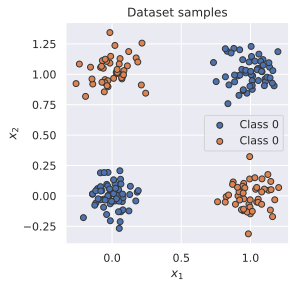

In [ ]:
visualize_samples(dataset.data, dataset.label)
plt.show()

In [ ]:
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)

In [ ]:
data_inputs, data_labels = next(iter(data_loader))

print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs torch.Size([8, 2]) 
 tensor([[-0.0154,  1.0919],
        [ 1.1439, -0.1164],
        [-0.0830,  1.0569],
        [ 0.9938,  0.1391],
        [ 0.0710,  0.9620],
        [ 0.8318,  1.1893],
        [ 0.9502, -0.1090],
        [-0.0840,  0.1897]])
Data labels torch.Size([8]) 
 tensor([1, 1, 1, 1, 1, 0, 1, 0])


In [ ]:
loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)